In [28]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.init as init

torch.manual_seed(24)

MASS = 1.0
HBAR = 1.0
AUTOEV = 27.2114
AUTONM = 0.05291772108

# qGrid: 0.0 to 5.0; NGRID = 1024; 
# rGrid: 0.0 to 0.02*TWOPI / (NGRID * dq)    --> 0.0 to 25.7108; NGRID = 1024; 
NQGRID = 2048
qGrid = torch.linspace(0.0, 10.0, NQGRID, dtype=torch.float64)
dq = (10.0-0.0)/NQGRID

In [29]:
def plotBandStruct(bandStruct_array, marker_array, label_array): 
    fig, axs = plt.subplots(1,1, figsize=(3,3))
    for bandStructIndex in range(len(bandStruct_array)): 
        numBands = len(bandStruct_array[bandStructIndex][0])
        numKpts = len(bandStruct_array[bandStructIndex])
        for i in range(numBands): 
            if i==0: 
                axs.plot(np.arange(numKpts), bandStruct_array[bandStructIndex][:, i].detach().numpy(), marker_array[bandStructIndex], label=label_array[bandStructIndex])
            else: 
                axs.plot(np.arange(numKpts), bandStruct_array[bandStructIndex][:, i].detach().numpy(), marker_array[bandStructIndex])
    axs.legend(frameon=False)
    plt.show()
    return

def pot_func(x, params): 
    pot = (params[0]*(x*x - params[1]) / (params[2] * np.exp(params[3]*x*x) - 1.0))
    return pot
    
def plotPP(q_array, vq_Cd_array, vq_Se_array, label_array, lineshape_array): 
    fig, axs = plt.subplots(1,1, figsize=(3,3))
    for i in range(len(vq_Cd_array)): 
        q = q_array[i].detach().numpy()
        vq_Cd = vq_Cd_array[i].detach().numpy()
        vq_Se = vq_Se_array[i].detach().numpy()
        axs.plot(q, vq_Cd, lineshape_array[i], label="Cd "+label_array[i])
        axs.plot(q, vq_Se, lineshape_array[i], label="Se "+label_array[i])
    axs.set(xlabel=r"$q$", ylabel=r"$v(q)$")
    axs.legend(frameon=False)
    plt.show()
    return

In [30]:
# Semiconductor system details

nSystem = 1

# read system
scale = 11.4485278
unitCellVector1 = torch.tensor([0.0, 0.5, 0.5], dtype=torch.float64) * scale
unitCellVector2 = torch.tensor([0.5, 0.0, 0.5], dtype=torch.float64) * scale
unitCellVector3 = torch.tensor([0.5, 0.5, 0.0], dtype=torch.float64) * scale
unitCellVectors = torch.cat((unitCellVector1.unsqueeze(0), unitCellVector2.unsqueeze(0), unitCellVector3.unsqueeze(0)), dim=0)
cellVolume = torch.dot(unitCellVector1, torch.cross(unitCellVector2, unitCellVector3))

# calculate reciprocal space vectors
prefactor = 2 * np.pi / cellVolume
gVector1 = prefactor * torch.cross(unitCellVectors[1], unitCellVectors[2])
gVector2 = prefactor * torch.cross(unitCellVectors[2], unitCellVectors[0])
gVector3 = prefactor * torch.cross(unitCellVectors[0], unitCellVectors[1])
gVectors = torch.cat((gVector1.unsqueeze(0), gVector2.unsqueeze(0), gVector3.unsqueeze(0)), dim=0)

nAtoms = 2
atomTypes = np.array(["Cd", "Se"])
atomPos = torch.tensor([[0.125, 0.125, 0.125],
                        [-0.125, -0.125, -0.125]], dtype=torch.float64)
atomPos = atomPos @ unitCellVectors
# print(atomPos)

# read kPoints
kpt_zbCdSe = torch.tensor(np.loadtxt("ZB_kpoints.par"))
kpt_zbCdSe = kpt_zbCdSe @ gVectors
nkpt = kpt_zbCdSe.shape[0]
# Gamma = torch.tensor([0.0, 0.0, 0.0], dtype=torch.float64)

# read band strcture
Eref_zbCdSe = torch.tensor(np.loadtxt("bandStruct_zbCdSe.par")[:, 1:])

maxKE = 10

nBands = 16

In [31]:
# Current Cd, Se, S pp's in Zunger's form
CdParams = torch.tensor([-31.4518, 1.3890, -0.0502, 1.6603, 0.0586], dtype=torch.float64)
SeParams = torch.tensor([8.4921, 4.3513, 1.3600, 0.3227, 0.1746], dtype=torch.float64)
SParams = torch.tensor([7.6697, 4.5192, 1.3456, 0.3035, 0.2087], dtype=torch.float64)
PP_order = np.array(["Cd", "Se", "S"])
totalParams = torch.cat((CdParams.unsqueeze(0), SeParams.unsqueeze(0), SParams.unsqueeze(0)), dim=0)

CdPP = pot_func(qGrid, CdParams)
SePP = pot_func(qGrid, SeParams)
# totalPP = torch.cat((CdPP.unsqueeze(0), SePP.unsqueeze(0)), dim=0)

In [32]:
def basis(maxKE, scale, unitCellVectors, gVectors, cellVolume): 
    minGMag = min(torch.norm(gVectors[0]), torch.norm(gVectors[1]), torch.norm(gVectors[2]))
    numMaxBasisVectors = int(np.sqrt(2*maxKE) / minGMag)
    # print(numMaxBasisVectors)

    k = torch.arange(-numMaxBasisVectors, numMaxBasisVectors+1, dtype=torch.float64).repeat((2*numMaxBasisVectors+1)**2)
    j = torch.arange(-numMaxBasisVectors, numMaxBasisVectors+1, dtype=torch.float64).repeat_interleave((2*numMaxBasisVectors+1)).repeat((2*numMaxBasisVectors+1))
    i = torch.arange(-numMaxBasisVectors, numMaxBasisVectors+1, dtype=torch.float64).repeat_interleave((2*numMaxBasisVectors+1)**2)
    allGrid = torch.vstack((i, j, k)).T
    transform = gVectors.T
    allBasisSet = allGrid @ transform
    # print(allBasisSet.shape[0])
    # print(allBasisSet)

    row_norms = torch.norm(allBasisSet, dim=1)
    condition = (HBAR*0.5*row_norms**2 / MASS < maxKE)
    indices = torch.where(condition)[0]
    basisSet = allBasisSet[indices]
    # print(basisSet.shape[0])
    # print(basisSet)
    
    sorting_indices = torch.argsort(basisSet[:, 2], stable=True)
    basisSet = basisSet[sorting_indices]
    sorting_indices = torch.argsort(basisSet[:, 1], stable=True)
    basisSet = basisSet[sorting_indices]
    sorting_indices = torch.argsort(basisSet[:, 0], stable=True)
    basisSet = basisSet[sorting_indices]
    row_norms = torch.norm(basisSet, dim=1)
    sorting_indices = torch.argsort(row_norms[:], stable=True)
    sorted_basisSet = basisSet[sorting_indices]
    
    return sorted_basisSet

# construct hamiltonian at a certain k-point (kVector). Quicker through vectorization. 
def calcHamiltonianMatrix(NN_boolean, basisStates, kVector, nAtoms, cellVolume):
    n = basisStates.shape[0]
    HMatrix = torch.zeros((n, n), dtype=torch.complex128)

    # Kinetic energy
    for i in range(n): 
        HMatrix[i,i] += HBAR**2 / (2*MASS) * (torch.norm(basisStates[i] + kVector))**2
        
    # Local potential
    gDiff = torch.stack([basisStates] * (basisStates.shape[0]), dim=1) - basisStates.repeat(basisStates.shape[0], 1, 1)
    
    for k in range(nAtoms): 
        gDiffDotTau = torch.sum(gDiff * atomPos[k], axis=2)
        structFact = 1/cellVolume * (torch.cos(gDiffDotTau) + 1j*torch.sin(gDiffDotTau))

        thisAtomIndex = np.where(atomTypes[k]==PP_order)[0]
        if len(thisAtomIndex)!=1: 
            raise ValueError("Type of atoms in PP. ")
        thisAtomIndex = thisAtomIndex[0]
        
        if NN_boolean: 
            atomFF = PPmodel(torch.norm(gDiff, dim=2).view(-1, 1))
            atomFF = atomFF[:, thisAtomIndex].view(n, n)
        else: 
            atomFF = pot_func(torch.norm(gDiff, dim=2), totalParams[thisAtomIndex])
        
        HMatrix += atomFF * structFact
    return HMatrix

def calcBandStruct(NN_boolean, basisStates, nkpt, kpts_coord, nAtoms, cellVolume, nBands): 
    bandStruct = torch.zeros((nkpt, nBands), dtype=torch.float64)
    for kpt_index in range(nkpt): 
        HamiltonianMatrixAtKpt = calcHamiltonianMatrix(NN_boolean, basisStates, kpts_coord[kpt_index], nAtoms, cellVolume)

        # diagonalize the hamiltonian
        energies = torch.linalg.eigvalsh(HamiltonianMatrixAtKpt)
        
        energiesEV = energies * AUTOEV
        # 2-fold degeneracy due to spin
        final_energies = energiesEV.repeat_interleave(2)[:nBands]
    
        bandStruct[kpt_index] = final_energies

    return bandStruct

tensor([[ 0.8000, -1.7540],
        [ 0.7114,  0.9516]], dtype=torch.float64, grad_fn=<AddmmBackward0>)


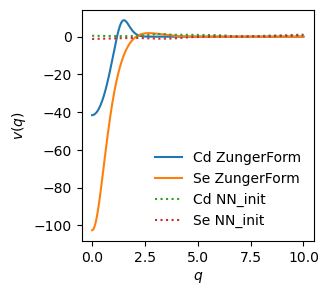

In [33]:
# Create Net model class
'''
class Net(nn.Module):
    # Constructor
    def __init__(self, Layers):
        super(Net, self).__init__()
        self.hidden = nn.ModuleList()
        self.batch_norm = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            layer = nn.Linear(input_size, output_size, dtype=torch.float64)
            init.xavier_normal_(layer.weight)
            init.constant_(layer.bias, 0)
            self.hidden.append(layer)
            if output_size != Layers[-1]:
                self.batch_norm.append(nn.BatchNorm1d(output_size, dtype=torch.float64))
    # Prediction
    def forward(self, activation):
        L = len(self.hidden)
        for (l, linear_transform) in enumerate(self.hidden):
            if l < L - 1:
                activation = torch.relu(linear_transform(activation))
                activation = self.batch_norm[l](activation)
            else:
                activation = linear_transform(activation)
        return activation

Layers = [1, 20, 2]
PPmodel = Net(Layers)
'''

# Added batch normalization, xavier initialization
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.input_layer = nn.Linear(1, 20, dtype=torch.float64) 
        self.bn1 = nn.BatchNorm1d(20, dtype=torch.float64) 

        self.hidden_layer1 = nn.Linear(20, 20, dtype=torch.float64) 
        self.bn2 = nn.BatchNorm1d(20, dtype=torch.float64)  

        self.hidden_layer2 = nn.Linear(20, 20, dtype=torch.float64) 
        self.bn3 = nn.BatchNorm1d(20, dtype=torch.float64) 

        self.output_layer = nn.Linear(20, 2, dtype=torch.float64) 

        # Xavier initialization for weights
        init.xavier_normal_(self.input_layer.weight)
        init.xavier_normal_(self.hidden_layer1.weight)
        init.xavier_normal_(self.hidden_layer2.weight)
        init.xavier_normal_(self.output_layer.weight)

    def forward(self, x):
        x = torch.relu(self.bn1(self.input_layer(x)))  
        x = torch.relu(self.bn2(self.hidden_layer1(x)))
        x = torch.relu(self.bn3(self.hidden_layer2(x)))
        x = self.output_layer(x)
        return x

PPmodel = Net()


# print("list(model.parameters()):\n ", list(PPmodel.parameters()))
# print("\nmodel.state_dict():\n ", PPmodel.state_dict())
print(PPmodel(torch.tensor([[1.0], [2.0]], dtype=torch.float64)))
# print(PPmodel(torch.tensor([[1.0]], dtype=torch.float64)))

# Validating on the initialized NN model
NN_init = PPmodel(qGrid.view(-1, 1))
plotPP([qGrid, qGrid], [CdPP, NN_init[:, 0]], [SePP, NN_init[:, 1]], ["ZungerForm", "NN_init"], ["-", ":"])

Epoch [100/1000], Loss: 3.1647


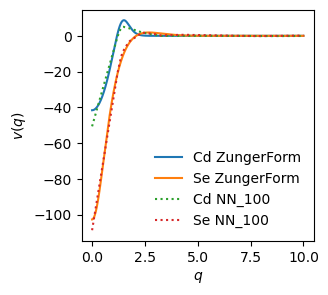

Epoch [200/1000], Loss: 2.1834


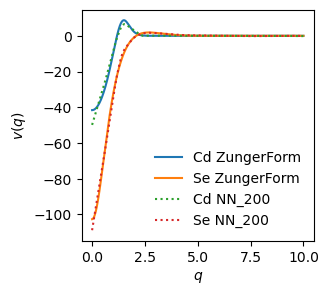

Epoch [300/1000], Loss: 1.3577


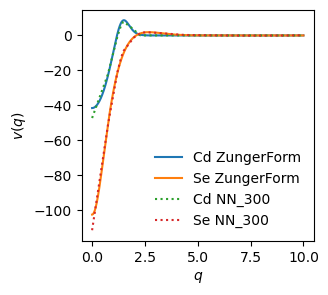

Epoch [400/1000], Loss: 0.7877


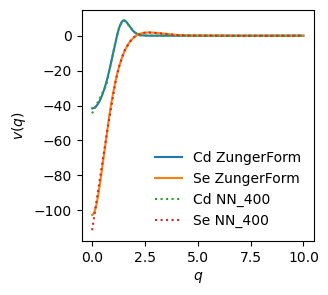

Epoch [500/1000], Loss: 0.6248


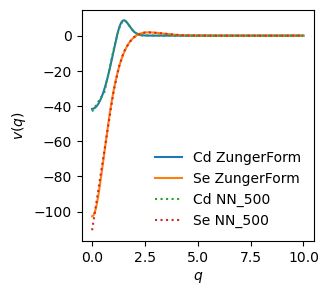

Epoch [600/1000], Loss: 0.4052


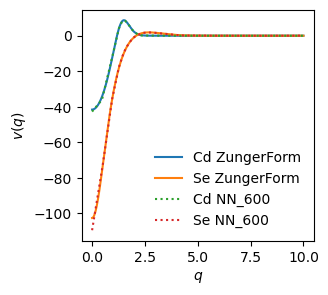

Epoch [700/1000], Loss: 0.2078


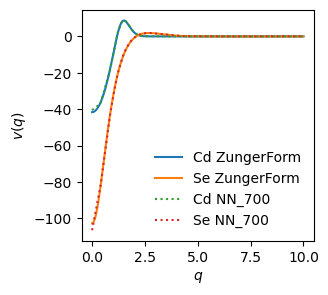

Epoch [800/1000], Loss: 0.0800


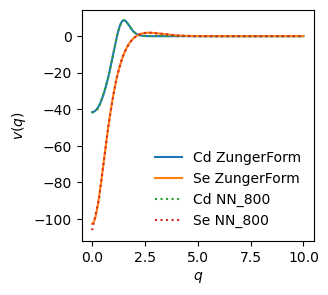

Epoch [900/1000], Loss: 0.0589


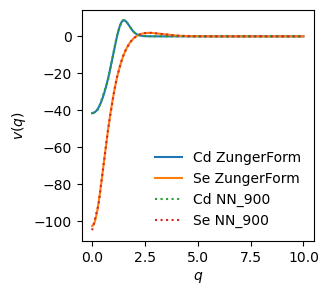

Epoch [1000/1000], Loss: 0.0507


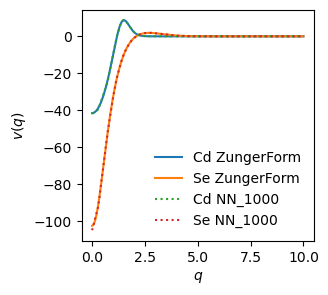

In [34]:
# Initialize the NN parameters to fit the current Zunger form
def totalMSELoss(output, target):
    loss = torch.mean((output - target) ** 2)
    return loss

optimizer = torch.optim.Adam(PPmodel.parameters(), lr=0.1)
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    inputs = qGrid.reshape(-1, 1)
    CdOutputs = PPmodel(inputs)[:,0]
    SeOutputs = PPmodel(inputs)[:,1]
    
    CdTargets = torch.zeros_like(CdOutputs)
    SeTargets = torch.zeros_like(CdOutputs)
    for i, x in enumerate(qGrid):
        CdTargets[i] = pot_func(x, CdParams)
        SeTargets[i] = pot_func(x, SeParams)
    
    loss = totalMSELoss(CdOutputs, CdTargets) + totalMSELoss(SeOutputs, SeTargets)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        
        NN_init = PPmodel(qGrid.view(-1, 1))
        plotPP([qGrid, qGrid], [CdPP, NN_init[:, 0]], [SePP, NN_init[:, 1]], ["ZungerForm", f"NN_{epoch+1}"], ["-", ":"]);

In [ ]:
basisStates = basis(maxKE, scale, unitCellVectors, gVectors, cellVolume)

current_Zunger_BandStruct = calcBandStruct(False, basisStates, nkpt, kpt_zbCdSe, nAtoms, cellVolume, nBands)
plotBandStruct([Eref_zbCdSe, current_Zunger_BandStruct], ["bo", "g-"], ["Reference zbCdSe", "Current Zunger"])
print("Using the this code, can I reproduce the reference band structure to within 1e-11 eV? ")
print(torch.allclose(E_zbCdSe, current_Zunger_BandStruct, atol=1e-11))


NN_init_BandStruct = calcBandStruct(True, basisStates, nkpt, kpt_zbCdSe, nAtoms, cellVolume, nBands)
plotBandStruct([Eref_zbCdSe, NN_init_BandStruct, current_Zunger_BandStruct], ["bo", "r-", "g-"], ["Reference zbCdSe", "NN_init", "Current Zunger"])

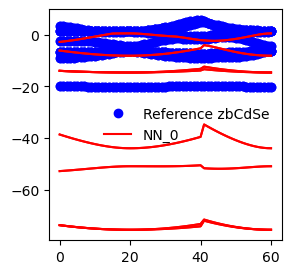

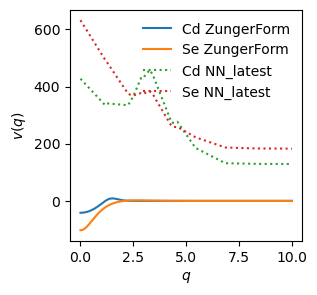

Loss: 1390.669329980506
Parameter: input_layer.weight, Gradient Norm: 0.0004960143264750068
Parameter: input_layer.bias, Gradient Norm: 7.70664120724784e-12
Parameter: bn1.weight, Gradient Norm: 4004.9588453264587
Parameter: bn1.bias, Gradient Norm: 998.7918800088858
Parameter: hidden_layer1.weight, Gradient Norm: 2187.9555284114235
Parameter: hidden_layer1.bias, Gradient Norm: 7.088719689677794e-13
Parameter: bn2.weight, Gradient Norm: 2148.331764238127
Parameter: bn2.bias, Gradient Norm: 501.3073995711965
Parameter: hidden_layer2.weight, Gradient Norm: 1155.382389574904
Parameter: hidden_layer2.bias, Gradient Norm: 8.827978829921086e-13
Parameter: bn3.weight, Gradient Norm: 2035.9056484194537
Parameter: bn3.bias, Gradient Norm: 1388.8575883818105
Parameter: output_layer.weight, Gradient Norm: 1737.6356646326392
Parameter: output_layer.bias, Gradient Norm: 0.2349826952281841


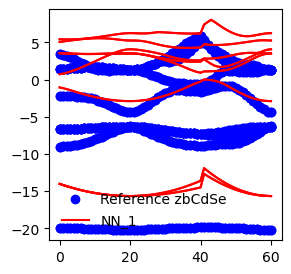

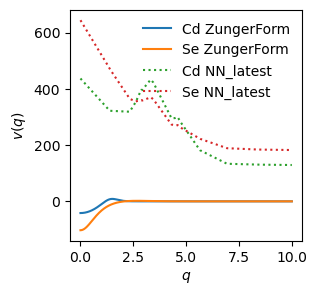

Loss: 30.558613727312373
Parameter: input_layer.weight, Gradient Norm: 4.068626018269209e-06
Parameter: input_layer.bias, Gradient Norm: 2.585068445316386e-13
Parameter: bn1.weight, Gradient Norm: 41.332477646470736
Parameter: bn1.bias, Gradient Norm: 37.2089870304583
Parameter: hidden_layer1.weight, Gradient Norm: 24.97158476101115
Parameter: hidden_layer1.bias, Gradient Norm: 2.2740396818964046e-14
Parameter: bn2.weight, Gradient Norm: 27.992294097137755
Parameter: bn2.bias, Gradient Norm: 30.06484843330235
Parameter: hidden_layer2.weight, Gradient Norm: 43.05122926680426
Parameter: hidden_layer2.bias, Gradient Norm: 4.087028447415655e-15
Parameter: bn3.weight, Gradient Norm: 43.72481721293454
Parameter: bn3.bias, Gradient Norm: 26.46318338956349
Parameter: output_layer.weight, Gradient Norm: 20.639288304955212
Parameter: output_layer.bias, Gradient Norm: 0.0017400882118612383


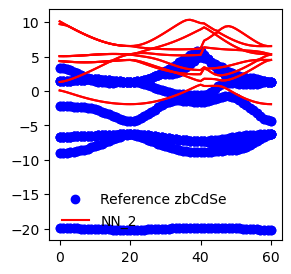

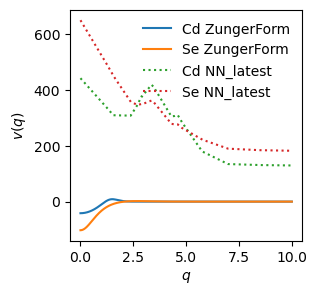

Loss: 108.03019552805418
Parameter: input_layer.weight, Gradient Norm: 1.2341734061658886e-05
Parameter: input_layer.bias, Gradient Norm: 3.3970018213142457e-13
Parameter: bn1.weight, Gradient Norm: 115.84434388594794
Parameter: bn1.bias, Gradient Norm: 100.39384567809724
Parameter: hidden_layer1.weight, Gradient Norm: 59.54200935616245
Parameter: hidden_layer1.bias, Gradient Norm: 1.029839733136735e-14
Parameter: bn2.weight, Gradient Norm: 67.7977736457946
Parameter: bn2.bias, Gradient Norm: 61.84679926572185
Parameter: hidden_layer2.weight, Gradient Norm: 106.32418045819092
Parameter: hidden_layer2.bias, Gradient Norm: 2.043183297994452e-14
Parameter: bn3.weight, Gradient Norm: 132.41819269694255
Parameter: bn3.bias, Gradient Norm: 82.39434228306183
Parameter: output_layer.weight, Gradient Norm: 68.65812105644851
Parameter: output_layer.bias, Gradient Norm: 0.00037425882766265676


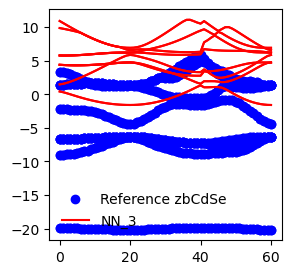

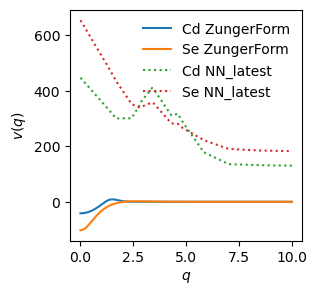

Loss: 115.79063433219989
Parameter: input_layer.weight, Gradient Norm: 1.2864473685527992e-05
Parameter: input_layer.bias, Gradient Norm: 6.246200595881549e-13
Parameter: bn1.weight, Gradient Norm: 125.81848042115492
Parameter: bn1.bias, Gradient Norm: 105.67531858557575
Parameter: hidden_layer1.weight, Gradient Norm: 52.667901304941495
Parameter: hidden_layer1.bias, Gradient Norm: 1.162232479745403e-14
Parameter: bn2.weight, Gradient Norm: 64.393898499611
Parameter: bn2.bias, Gradient Norm: 72.90189541800474
Parameter: hidden_layer2.weight, Gradient Norm: 117.97090532341299
Parameter: hidden_layer2.bias, Gradient Norm: 1.9499081561722775e-14
Parameter: bn3.weight, Gradient Norm: 129.68251423656338
Parameter: bn3.bias, Gradient Norm: 79.63737987008885
Parameter: output_layer.weight, Gradient Norm: 67.71930253378152
Parameter: output_layer.bias, Gradient Norm: 0.0006007600806687121


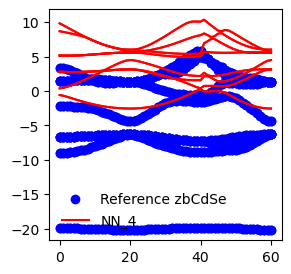

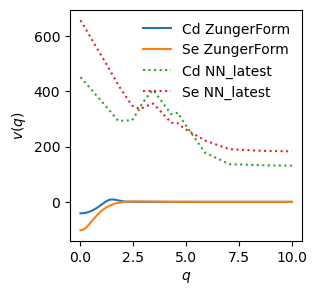

Loss: 95.10586841926164
Parameter: input_layer.weight, Gradient Norm: 9.146380197598685e-06
Parameter: input_layer.bias, Gradient Norm: 4.2366486136055473e-13
Parameter: bn1.weight, Gradient Norm: 97.85263731019569
Parameter: bn1.bias, Gradient Norm: 87.68746367795539
Parameter: hidden_layer1.weight, Gradient Norm: 40.17127961327363
Parameter: hidden_layer1.bias, Gradient Norm: 2.7244781330200408e-15
Parameter: bn2.weight, Gradient Norm: 50.347781307466455
Parameter: bn2.bias, Gradient Norm: 57.90044937933283
Parameter: hidden_layer2.weight, Gradient Norm: 88.76534775777057
Parameter: hidden_layer2.bias, Gradient Norm: 1.9347941542201278e-14
Parameter: bn3.weight, Gradient Norm: 115.12725696954908
Parameter: bn3.bias, Gradient Norm: 66.2565814540252
Parameter: output_layer.weight, Gradient Norm: 61.717250874386266
Parameter: output_layer.bias, Gradient Norm: 0.0007648757373741695


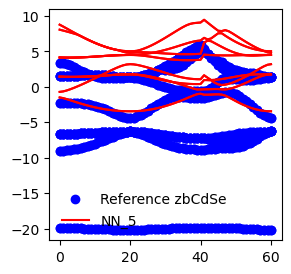

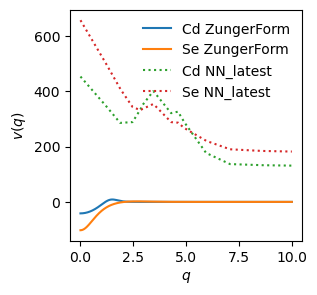

Loss: 77.17852506038216
Parameter: input_layer.weight, Gradient Norm: 7.163660561697603e-06
Parameter: input_layer.bias, Gradient Norm: 2.1099545722710133e-13
Parameter: bn1.weight, Gradient Norm: 84.62364863745718
Parameter: bn1.bias, Gradient Norm: 77.92034605858484
Parameter: hidden_layer1.weight, Gradient Norm: 33.48999571858653
Parameter: hidden_layer1.bias, Gradient Norm: 2.842173232579803e-15
Parameter: bn2.weight, Gradient Norm: 41.85448864864848
Parameter: bn2.bias, Gradient Norm: 47.423944287491636
Parameter: hidden_layer2.weight, Gradient Norm: 71.68188846825137
Parameter: hidden_layer2.bias, Gradient Norm: 3.152633551806853e-14
Parameter: bn3.weight, Gradient Norm: 101.60186039193371
Parameter: bn3.bias, Gradient Norm: 57.09578892749366
Parameter: output_layer.weight, Gradient Norm: 56.219073224135585
Parameter: output_layer.bias, Gradient Norm: 0.000892675495846766


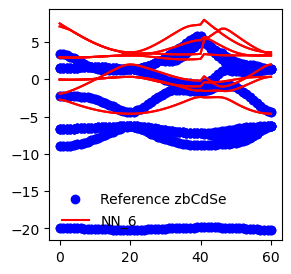

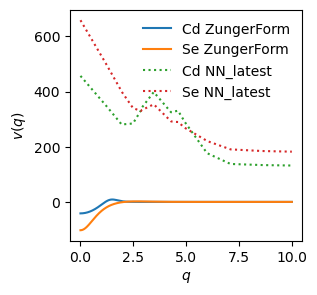

Loss: 59.039773229708146
Parameter: input_layer.weight, Gradient Norm: 6.613123613904144e-06
Parameter: input_layer.bias, Gradient Norm: 5.785690804816612e-13
Parameter: bn1.weight, Gradient Norm: 76.99125695433723
Parameter: bn1.bias, Gradient Norm: 72.39344666751848
Parameter: hidden_layer1.weight, Gradient Norm: 27.760284793862734
Parameter: hidden_layer1.bias, Gradient Norm: 4.4774946555608526e-15
Parameter: bn2.weight, Gradient Norm: 32.88144976179768
Parameter: bn2.bias, Gradient Norm: 39.00172814470094
Parameter: hidden_layer2.weight, Gradient Norm: 57.85102702786774
Parameter: hidden_layer2.bias, Gradient Norm: 1.0952804131297935e-14
Parameter: bn3.weight, Gradient Norm: 77.78744573327006
Parameter: bn3.bias, Gradient Norm: 39.788865650551635
Parameter: output_layer.weight, Gradient Norm: 48.78201891049815
Parameter: output_layer.bias, Gradient Norm: 0.0009823543334708301


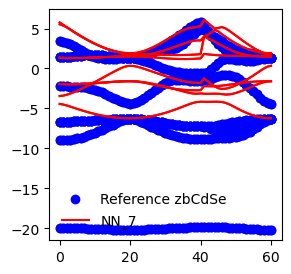

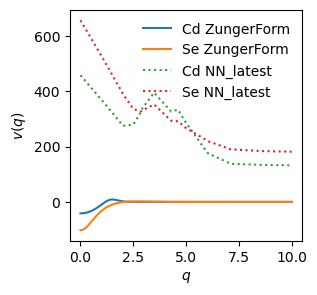

Loss: 40.40621331295719
Parameter: input_layer.weight, Gradient Norm: 5.5303630801139e-06
Parameter: input_layer.bias, Gradient Norm: 3.067369385041709e-13
Parameter: bn1.weight, Gradient Norm: 60.362659858104486
Parameter: bn1.bias, Gradient Norm: 55.48401748343091
Parameter: hidden_layer1.weight, Gradient Norm: 21.24504789513939
Parameter: hidden_layer1.bias, Gradient Norm: 3.393866270836275e-15
Parameter: bn2.weight, Gradient Norm: 29.90754175072155
Parameter: bn2.bias, Gradient Norm: 29.676819139527808
Parameter: hidden_layer2.weight, Gradient Norm: 45.455814728746525
Parameter: hidden_layer2.bias, Gradient Norm: 7.991849204380777e-15
Parameter: bn3.weight, Gradient Norm: 57.5078556541985
Parameter: bn3.bias, Gradient Norm: 29.492164022584493
Parameter: output_layer.weight, Gradient Norm: 37.31349447761529
Parameter: output_layer.bias, Gradient Norm: 0.0009987167797616938


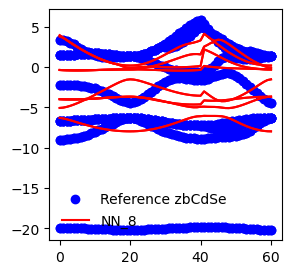

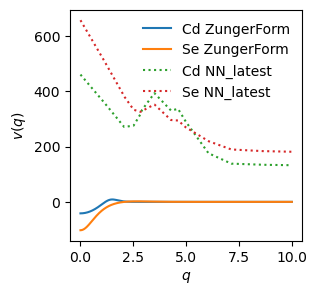

Loss: 26.58007508103257
Parameter: input_layer.weight, Gradient Norm: 3.6980337381088643e-06
Parameter: input_layer.bias, Gradient Norm: 5.647556531104038e-14
Parameter: bn1.weight, Gradient Norm: 31.056377543931273
Parameter: bn1.bias, Gradient Norm: 19.806669986334136
Parameter: hidden_layer1.weight, Gradient Norm: 13.559591035333726
Parameter: hidden_layer1.bias, Gradient Norm: 2.8863988594640226e-15
Parameter: bn2.weight, Gradient Norm: 19.97053252734938
Parameter: bn2.bias, Gradient Norm: 18.254045384707894
Parameter: hidden_layer2.weight, Gradient Norm: 29.035015580506883
Parameter: hidden_layer2.bias, Gradient Norm: 2.9257926303396844e-15
Parameter: bn3.weight, Gradient Norm: 34.89208790714795
Parameter: bn3.bias, Gradient Norm: 17.67633361824417
Parameter: output_layer.weight, Gradient Norm: 23.305282698310197
Parameter: output_layer.bias, Gradient Norm: 0.0009604229647084677


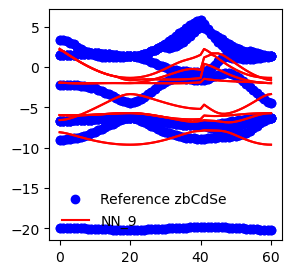

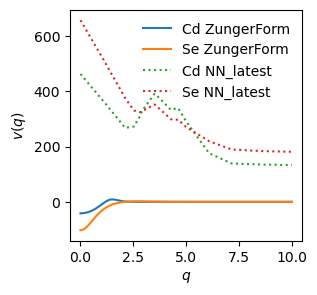

Loss: 19.661437397964935
Parameter: input_layer.weight, Gradient Norm: 1.6295306057806097e-06
Parameter: input_layer.bias, Gradient Norm: 5.497573704292321e-14
Parameter: bn1.weight, Gradient Norm: 14.262236767337987
Parameter: bn1.bias, Gradient Norm: 8.747647976808485
Parameter: hidden_layer1.weight, Gradient Norm: 5.893153590279878
Parameter: hidden_layer1.bias, Gradient Norm: 8.132708279108512e-15
Parameter: bn2.weight, Gradient Norm: 9.050130195494134
Parameter: bn2.bias, Gradient Norm: 6.879653574489353
Parameter: hidden_layer2.weight, Gradient Norm: 11.623809960741484
Parameter: hidden_layer2.bias, Gradient Norm: 3.8235721075052845e-15
Parameter: bn3.weight, Gradient Norm: 13.174294271421344
Parameter: bn3.bias, Gradient Norm: 6.1573352099223655
Parameter: output_layer.weight, Gradient Norm: 8.829700306968757
Parameter: output_layer.bias, Gradient Norm: 0.0008923157410720675


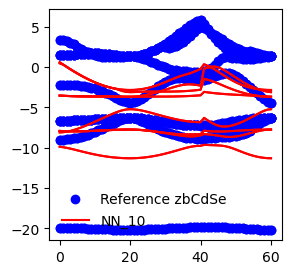

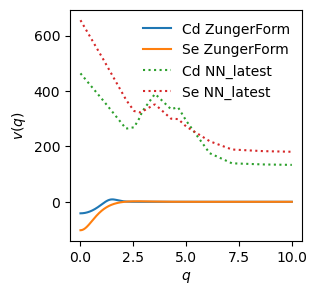

Loss: 18.647542348951962
Parameter: input_layer.weight, Gradient Norm: 1.0187447454927522e-06
Parameter: input_layer.bias, Gradient Norm: 5.739000548710147e-14
Parameter: bn1.weight, Gradient Norm: 7.130035731094572
Parameter: bn1.bias, Gradient Norm: 5.16824480311654
Parameter: hidden_layer1.weight, Gradient Norm: 2.741233566508894
Parameter: hidden_layer1.bias, Gradient Norm: 3.390305030509445e-15
Parameter: bn2.weight, Gradient Norm: 4.9855805448287684
Parameter: bn2.bias, Gradient Norm: 5.17091878113402
Parameter: hidden_layer2.weight, Gradient Norm: 8.172147299756542
Parameter: hidden_layer2.bias, Gradient Norm: 1.1113943590184457e-15
Parameter: bn3.weight, Gradient Norm: 9.184057012383466
Parameter: bn3.bias, Gradient Norm: 5.980559350855098
Parameter: output_layer.weight, Gradient Norm: 7.155472700420471
Parameter: output_layer.bias, Gradient Norm: 0.0007857049479223571


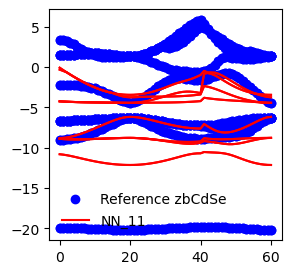

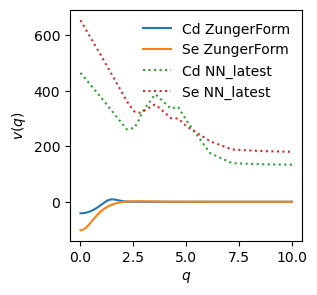

Loss: 19.96538694799637
Parameter: input_layer.weight, Gradient Norm: 1.0582025929066033e-06
Parameter: input_layer.bias, Gradient Norm: 4.2319557014690206e-14
Parameter: bn1.weight, Gradient Norm: 10.04590465501685
Parameter: bn1.bias, Gradient Norm: 9.03787556263952
Parameter: hidden_layer1.weight, Gradient Norm: 6.096728494952527
Parameter: hidden_layer1.bias, Gradient Norm: 2.810965870786061e-15
Parameter: bn2.weight, Gradient Norm: 11.500453646295911
Parameter: bn2.bias, Gradient Norm: 8.792150067438097
Parameter: hidden_layer2.weight, Gradient Norm: 11.459982660238694
Parameter: hidden_layer2.bias, Gradient Norm: 4.2505437059025255e-15
Parameter: bn3.weight, Gradient Norm: 21.455869525708323
Parameter: bn3.bias, Gradient Norm: 11.809097959498056
Parameter: output_layer.weight, Gradient Norm: 14.97287619612381
Parameter: output_layer.bias, Gradient Norm: 0.0007241685198592108


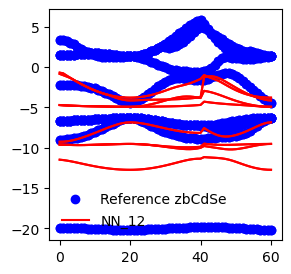

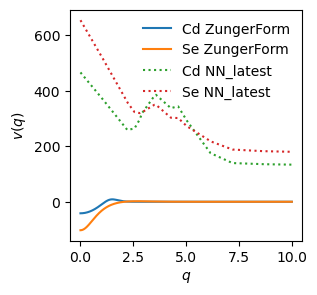

Loss: 21.46419384795934
Parameter: input_layer.weight, Gradient Norm: 1.5476652953977269e-06
Parameter: input_layer.bias, Gradient Norm: 1.0743698138801531e-13
Parameter: bn1.weight, Gradient Norm: 15.395584080443209
Parameter: bn1.bias, Gradient Norm: 11.789610382178797
Parameter: hidden_layer1.weight, Gradient Norm: 8.280660951047581
Parameter: hidden_layer1.bias, Gradient Norm: 3.7367108795187575e-15
Parameter: bn2.weight, Gradient Norm: 14.619746290166635
Parameter: bn2.bias, Gradient Norm: 11.635708726178303
Parameter: hidden_layer2.weight, Gradient Norm: 15.310060472325866
Parameter: hidden_layer2.bias, Gradient Norm: 5.87227679254872e-15
Parameter: bn3.weight, Gradient Norm: 29.31779562480242
Parameter: bn3.bias, Gradient Norm: 15.976457441765888
Parameter: output_layer.weight, Gradient Norm: 20.3975170309976
Parameter: output_layer.bias, Gradient Norm: 0.000677275336766446


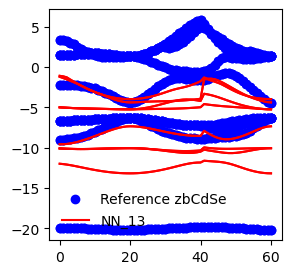

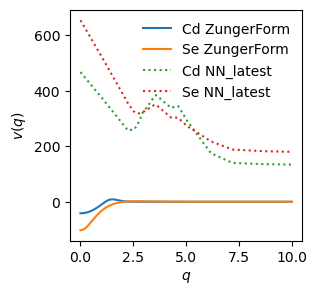

Loss: 22.617646671013187
Parameter: input_layer.weight, Gradient Norm: 1.749126761318606e-06
Parameter: input_layer.bias, Gradient Norm: 8.461862178870265e-14
Parameter: bn1.weight, Gradient Norm: 18.245217380336427
Parameter: bn1.bias, Gradient Norm: 14.039182496113872
Parameter: hidden_layer1.weight, Gradient Norm: 9.85971924622564
Parameter: hidden_layer1.bias, Gradient Norm: 5.914319942724859e-15
Parameter: bn2.weight, Gradient Norm: 17.813406355168674
Parameter: bn2.bias, Gradient Norm: 13.135301512666594
Parameter: hidden_layer2.weight, Gradient Norm: 16.948393854734235
Parameter: hidden_layer2.bias, Gradient Norm: 1.2547712589161547e-14
Parameter: bn3.weight, Gradient Norm: 33.53489269213707
Parameter: bn3.bias, Gradient Norm: 17.458408631315674
Parameter: output_layer.weight, Gradient Norm: 23.986044406599817
Parameter: output_layer.bias, Gradient Norm: 0.0006425118421692703


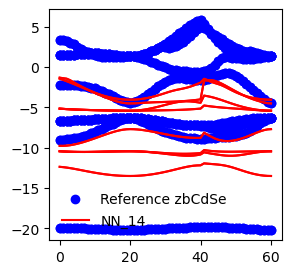

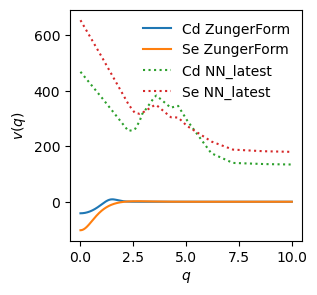

Loss: 23.385900704405575
Parameter: input_layer.weight, Gradient Norm: 2.0018339571443563e-06
Parameter: input_layer.bias, Gradient Norm: 9.446069389145829e-14
Parameter: bn1.weight, Gradient Norm: 21.05517060852471
Parameter: bn1.bias, Gradient Norm: 15.413888150145642
Parameter: hidden_layer1.weight, Gradient Norm: 10.783070374013246
Parameter: hidden_layer1.bias, Gradient Norm: 7.842210447471364e-15
Parameter: bn2.weight, Gradient Norm: 18.81165315079062
Parameter: bn2.bias, Gradient Norm: 14.158131810382923
Parameter: hidden_layer2.weight, Gradient Norm: 18.311384565655153
Parameter: hidden_layer2.bias, Gradient Norm: 9.090235014305122e-15
Parameter: bn3.weight, Gradient Norm: 36.81390711263493
Parameter: bn3.bias, Gradient Norm: 19.008852327904787
Parameter: output_layer.weight, Gradient Norm: 26.36328740358737
Parameter: output_layer.bias, Gradient Norm: 0.000613386172993253


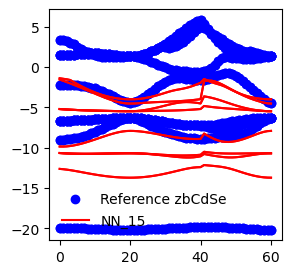

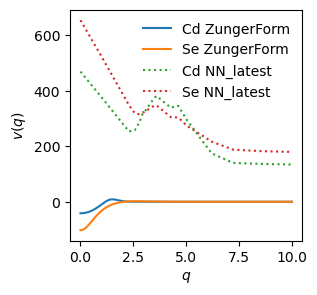

Loss: 23.594001088716528
Parameter: input_layer.weight, Gradient Norm: 2.1664836933394056e-06
Parameter: input_layer.bias, Gradient Norm: 1.0129736158626749e-13
Parameter: bn1.weight, Gradient Norm: 22.884995359317124
Parameter: bn1.bias, Gradient Norm: 16.274612616069266
Parameter: hidden_layer1.weight, Gradient Norm: 11.223301152395099
Parameter: hidden_layer1.bias, Gradient Norm: 3.605515363576297e-15
Parameter: bn2.weight, Gradient Norm: 19.07636852888393
Parameter: bn2.bias, Gradient Norm: 14.558210083278833
Parameter: hidden_layer2.weight, Gradient Norm: 18.869553640539166
Parameter: hidden_layer2.bias, Gradient Norm: 8.139485912813597e-15
Parameter: bn3.weight, Gradient Norm: 38.39425625758087
Parameter: bn3.bias, Gradient Norm: 19.68108943107293
Parameter: output_layer.weight, Gradient Norm: 27.546080850409506
Parameter: output_layer.bias, Gradient Norm: 0.000599342995855142


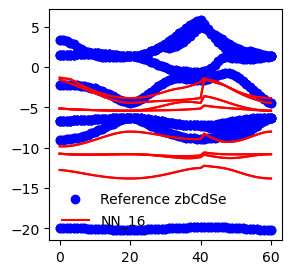

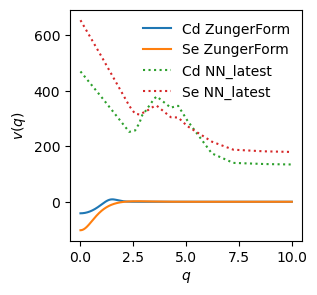

Loss: 23.177294370660036


In [ ]:
learning_rate = 0.1
optimizer = torch.optim.Adam(PPmodel.parameters(), lr = learning_rate)

# torch.autograd.set_detect_anomaly(False)

def train_model(epochs):
    for epoch in range(epochs):
        # for name, param in PPmodel.named_parameters():
        #     print(f"Parameter: {name}, Size: {param.size()}")
        #     print(param.data)
        NN_BandStruct = calcBandStruct(True, basisStates, nkpt, kpt_zbCdSe, nAtoms, cellVolume, nBands)
        plotBandStruct([Eref_zbCdSe, NN_BandStruct], ["bo", "r-"], ["Reference zbCdSe", "NN_"+str(epoch)])
        NN_latest = PPmodel(qGrid.view(-1, 1))
        plotPP([qGrid, qGrid], [CdPP, NN_latest[:, 0]], [SePP, NN_latest[:, 1]], ["ZungerForm", "NN_latest"], ["-", ":"])
        
        loss = ((Eref_zbCdSe - NN_BandStruct) ** 2).mean()
        print(f"Loss: {loss}")
        optimizer.zero_grad()
        loss.backward()
        for name, param in PPmodel.named_parameters():
            if param.grad is not None:
                print(f"Parameter: {name}, Gradient Norm: {param.grad.norm().item()}")
        optimizer.step()

train_model(30)

# NN_latest = PPmodel(qGrid.view(-1, 1))
# plotPP([qGrid, qGrid], [CdPP, NN_latest[:, 0]], [SePP, NN_latest[:, 1]], ["ZungerForm", "NN_latest"], ["-", ":"])

In [ ]:
'''
train_model(50)

NN_latest = PPmodel(qGrid.view(-1, 1))
plotPP([qGrid, qGrid], [CdPP, NN_latest[:, 0]], [SePP, NN_latest[:, 1]], ["ZungerForm", "NN_latest"], ["-", ":"])
'''